Author: Anne Sabourin
Description: DAMEX tutorial

# Damex tutorial

This notebook implements the DAMEX algorithm as described in [1]. The
unsupervised task considered is the discovery of groups of components
of a random vector that are comparatively likely to be simultaneously
large.

The tutorial introduces new methods for selecting the tuning parameter
$\epsilon$ in DAMEX and $\kappa$ in CLEF, primarily based on AIC and
cross-validation. These methods involve a specific pseudo-likelihood
for random subsets of features among $\{1, \ldots, d\}$. Although
these methods lack theoretical investigation, this notebook provides
empirical evidence supporting the relevance of the proposed selection
criteria.

**References:**
[1] Goix, N., Sabourin, A., & Clémençon, S. (2017). Sparse
representation of multivariate extremes with applications to anomaly
detection. Journal of Multivariate Analysis, 161, 12-31.

In [1]:
# # Set working directory if necessary
import os
os.getcwd()
# #os.chdir("../")

'/home/anne/Dropbox/RECHERCHE/CODE/MLExtreme/test'

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pprint as pp
import MLExtreme as mlx


# Define the norm function as the infinite norm (other norms are not
# implemented in DAMEX / CLEF). This definition is not required for
# running CLEF/DAMEX and is used here solely for visualization and
# analysis of the output.

def norm_func(x):
    return np.max(x, axis=1)

## Ground truth definition:
Define or generate a list of subfaces of the unit sphere that
represent the support of the limit measure.

In [8]:
Plot = False
seed = 42
dim = 20  # try 5, 20, 50, 100
num_subfaces = 10  # try 5, 20, 50
subfaces_list = mlx.gen_subfaces(dimension=dim,
                                 num_subfaces=num_subfaces,
                                 max_size=10,  # try 4, 10, 20
                                 prevent_inclusions=True,
                                 seed=seed)

# # Uncomment for a simpler example:
# subfaces_list = [[0, 1], [1, 2], [2, 3, 4]]

if False:   # change to True to print the list of subfaces
    print(subfaces_list)
    pp.pprint(mlx.list_to_dict_size(subfaces_list))

subfaces_matrix = mlx.subfaces_list_to_matrix(subfaces_list, dim)
# print(subfaces_matrix) Dimension, number of mixture components,
# weights and Dirichlet center locations
n = int(np.sqrt(dim) * 10**3)
k = np.shape(subfaces_matrix)[0]
dim = np.shape(subfaces_matrix)[1]
# Define admissible Dirichlet mixture parameters for the limit angular measure
# of a marginally Pareto-standardized heavy-tailed vector,
# based on the matrix of subfaces.
# This avoids potentially imbalanced settings across features.
wei = np.ones(k)/k
Mu, wei = mlx.normalize_param_dirimix(subfaces_matrix, wei)
# Print the subfaces and their weights, and record them as a list for
# further use.
faces_true = subfaces_list
wei_true = wei
print(f'Mu matrix: \n {np.round(Mu, 3)}')
print(f'Weights: {np.round(wei, 3)}')

Mu matrix: 
 [[0.3   0.    0.    0.4   0.    0.    0.    0.    0.3   0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.077 0.103 0.103 0.103 0.103 0.    0.103 0.077 0.    0.103 0.    0.
  0.154 0.    0.    0.    0.    0.    0.    0.077]
 [0.12  0.    0.    0.    0.    0.    0.16  0.12  0.    0.    0.    0.24
  0.    0.    0.    0.    0.24  0.    0.    0.12 ]
 [0.    0.    0.    0.    0.    0.    0.    0.136 0.136 0.    0.    0.
  0.    0.182 0.273 0.    0.    0.273 0.    0.   ]
 [0.2   0.    0.    0.    0.    0.8   0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.75  0.
  0.    0.25  0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.571 0.    0.    0.    0.429 0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.2   0.    0.2   0.    0.    0.    0.    0.15  0.    0.    0.
  0.    0.    0.3   0.    0.    0.    0.    0.15 ]
 [0.    0

### Difficulty Settings for the Tail Problem

The `lnu` parameter below is the logarithm of the concentration
parameter for the Dirichlet mixture. It is a crucial parameter that
determines the difficulty of the clustering problem. If any
$ \exp(\text{lnu}[i]) \times \text{Mu}[i,j] < 1$, the problem is
pathologically hard, as the mass on any subface concentrates on the
boundary of that face. Conversely, if all $\exp(\text{lnu}[i]) \times
\text{Mu}[i,j] \gg 1$, the problem is very easy.

Experiment with the 'difficulty' parameter below, which should be
strictly positive. Values greater than one correspond to very hard
problems, while values close to zero generate very easy
problems. Interesting results occur for difficulty $\approx 0.8$.

In [9]:
difficulty = 0.8

min_mus = np.zeros(k)
for j in range(k):
    min_mus[j] = np.min(Mu[j, Mu[j, :] > 0])
lnu = np.log(1/(difficulty**2) * 1/min_mus)
# check (change to True  to display)
if False:
    print("absolute dirichlet parameters: ")
    print(Mu * np.exp(lnu).reshape(-1, 1))

 Other parameter settings that govern the speed of convergence of
the conditional distribution above a radial threshold towards the
limit measure.  

In [10]:
# Regular variation index of the data
alpha = 2

# Centers of mass of the Dirichlet mixture in the bulk (vanishing
# impact above large radial thresholds):
Mu_bulk = np.ones((k, dim))/dim

 `index_weight_noise` below indicates how fast the impact of noise decreases
with large radial thresholds. Specifically, the noise's weight decreases as:
$(C/\text{radius})^{\text{index\_weight\_noise}}$

In [11]:
index_weight_noise = 4

### Dataset Generation and Visualisation

In [12]:
# Generate data
np.random.seed(42)
X = mlx.gen_rv_dirimix(alpha, np.round(Mu, 3),  wei, lnu,
                       scale_weight_noise=1, Mu_bulk=Mu_bulk,
                       index_weight_noise=index_weight_noise, size=n)


# Define rank-transformed data
Xt = mlx.rank_transform(X)

# Generate test data for unsupervised evaluation
np.random.seed(12345)
Xtest = mlx.gen_rv_dirimix(alpha, np.round(Mu, 3),  wei, lnu,
                           scale_weight_noise=1, Mu_bulk=Mu_bulk,
                           index_weight_noise=index_weight_noise, size=5*n)

# Define rank-transformed test data
std_Xtest = mlx.rank_transform(Xtest)

In [13]:
# pairwise plot of generated data for two dependent components
len_faces = np.sum(subfaces_matrix, axis=1)
r_i = np.where(len_faces > 1)[0][0]
iplot = subfaces_list[r_i][0]
jplot = subfaces_list[r_i][1]

if Plot:
    plt.figure(figsize=(10, 10))
    X_disp = X**(alpha/4)  # for easier visualization only
    max_val = np.max(X_disp)
    scatter = plt.scatter(X_disp[:, iplot], X_disp[:, jplot], alpha=0.5)
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature d')
    plt.title('Scatter Plot of the raw dataset')
    plt.show()

In [14]:
# Rank transformed  generated data with  unit pareto margins
# and visualization
if Plot:
    plt.figure(figsize=(10, 10))
    X_disp = Xt**(1/4)  # for easier viz only
    max_val = np.max(X_disp)
    scatter = plt.scatter(X_disp[:, iplot], X_disp[:, jplot], alpha=0.5)
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature d')
    plt.title('Scatter Plot of the rank transformed dataset')
    plt.show()

# Data Analysis
## Radial threshold selection before model fitting

In [15]:
# Select the radial threshold via distance-covariance tests.
# See the tutorials on classification and regression for more details.
ntests_thresh = 10
ratio_ext = np.geomspace(0.05, 0.3, num=ntests_thresh)
pval, ratio_max = mlx.test_indep_radius_rest(Xt, y=None, ratio_ext=ratio_ext,
                                             norm_func=norm_func)

if Plot:
    mlx.plot_indep_radius_rest(pval, ratio_ext, ratio_max, n)

print(f'maximum ratio of extreme samples from rule-of-thumb \
distance covariance test: {mlx.round_signif(ratio_max, 2)}')
ratio_extremes = ratio_max * 4/5
norm_Xt = norm_func(Xt)
# Radial threshold selected with rule-of-thumb radius-versus-rest
# independence tests:
threshold = np.quantile(norm_Xt, 1 - ratio_extremes)
# Note: The following is not 'k' in the notations of Goix et al.'s
# paper.  Instead, it is between k and d * k. It is the number of data
# points above the radial threshold.
number_extremes = np.sum(norm_Xt >= threshold)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

maximum ratio of extreme samples from rule-of-thumb distance covariance test: 0.2


## DAMEX CLUSTERING ALGORITHM (Goix et al.)

In [16]:
# value epsilon = 0.1.
include_singletons = True
min_counts = 10
clustering = mlx.damex(min_counts=min_counts,
                       thresh_train=threshold, thresh_test=threshold,
                       include_singletons=include_singletons)
damex_subfaces, damex_masses = clustering.fit(X)

In [17]:
# Visualization of rank-transformed data and threshold (default; epsilon=0.1)
Xt_disp = Xt**(1/4)
thresh_disp = clustering.thresh_train**(1/4)
eps_thresh_disp = (clustering.thresh_train * clustering.epsilon)**(1/4)
max_val = np.max(Xt_disp)*1.01
# # Note: The exponent alpha/4 above is meant to aid visualization
# # only and may be removed without altering the analysis.
if Plot:
    scatter = plt.scatter(Xt_disp[:, iplot], Xt_disp[:, jplot], alpha=0.5,
                          c='gray')
    plt.xlim(0.9, max_val)
    plt.ylim(0.9, max_val)
    plt.plot([thresh_disp, thresh_disp], [0, thresh_disp], c='blue',
             label='radial threshold')
    plt.plot([0, thresh_disp], [thresh_disp, thresh_disp], c='blue')
    plt.plot([thresh_disp, max_val], [eps_thresh_disp, eps_thresh_disp],
             c='red',
             label='tolerance distance-to-subface threshold')
    plt.plot([eps_thresh_disp, eps_thresh_disp], [thresh_disp, max_val],
             c='red')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature d')
    plt.title('Scatter Plot of the rank_transformed dataset and \
selected thresholds')
    plt.legend()
    plt.show()

inspection of subfaces and masses

In [18]:
faces_dict, mass_dict = mlx.list_to_dict(damex_subfaces,
                                         damex_masses)

faces_dict_true, mass_dict_true = mlx.list_to_dict(faces_true, wei_true)

if True:
    print("List of subfaces found by DAMEX:")
    pp.pprint(faces_dict)
    print("(Damex) Associated limit mass:")
    print(mass_dict)
    print("True  list of subfaces: ")
    pp.pprint(faces_dict_true)
    print("(True) Associated limit mass:")
    print(mass_dict_true)

List of subfaces found by DAMEX:
{1: [],
 2: [[10, 13], [0, 5], [4, 8]],
 3: [[0, 3, 8]],
 4: [[7, 13, 14, 17]],
 5: [[7, 8, 13, 14, 17],
     [1, 3, 8, 14, 19],
     [9, 11, 12, 16, 17],
     [2, 11, 12, 16, 17]],
 6: [[2, 9, 11, 12, 16, 17], [0, 6, 7, 11, 16, 19]],
 7: [],
 8: [],
 9: [],
 10: [[0, 1, 2, 3, 4, 6, 7, 9, 12, 19]]}
(Damex) Associated limit mass:
{1: [], 2: [0.97, 0.95, 0.82], 3: [0.66], 4: [0.18], 5: [0.68, 0.58, 0.22, 0.2], 6: [0.62, 0.31], 7: [], 8: [], 9: [], 10: [0.26]}
True  list of subfaces: 
{1: [],
 2: [[0, 5], [10, 13], [4, 8]],
 3: [[0, 3, 8]],
 4: [],
 5: [[7, 8, 13, 14, 17], [1, 3, 8, 14, 19]],
 6: [[0, 6, 7, 11, 16, 19], [2, 9, 11, 12, 16, 17]],
 7: [],
 8: [],
 9: [],
 10: [[0, 1, 2, 3, 4, 6, 7, 9, 12, 19], [1, 2, 4, 6, 7, 9, 13, 15, 18, 19]]}
(True) Associated limit mass:
{1: [], 2: [0.062, 0.067, 0.029], 3: [0.042], 4: [], 5: [0.092, 0.083], 6: [0.1, 0.13], 7: [], 8: [], 9: [], 10: [0.16, 0.22]}


## Unsupervised scoring

This material presents novel concepts, not yet supported by formal
published theory, but intuitive and practical. It aids in evaluating
goodness-of-fit, and most importantly, selecting the
parameter `epsilon` (or `kappa_min` in CLEF). The ideas are related to
Jorgensen's *Theory of Dispersion Models*.

We introduce an unsupervised performance metric termed *Total
Deviance*, inspired by Jorgensen's work. This metric relies on a unit
deviance function $ d(\text{subface}_1, \text{subface}_2) $, defined
as in Chiapino et al. as the ratio of the symmetric difference between
the index sets of two subfaces to the cardinality of the union of
these index sets.

Given a unit deviance $ d $, the total deviance of an estimated pair
(list of subfaces, list of masses) from Damex or CLEF, with respect to
an extreme dataset, is computed as follows:

1. Each extreme point $ X_i $ is transformed into a binary vector
using the same "mask" as in Damex/CLEF. For Damex, $ X_{i,j} = 1 $
if $ ||X_i|| > \text{threshold} $ and $ X_{i,j} > \epsilon \times
\text{threshold} $; otherwise, $ X_{i,j} = 0 $. In CLEF, this
condition applies with $ \epsilon = 1 $.

2. Each binary-transformed extreme point is identified with a subface
by considering its non-zero entries as the indices defining the
subface. This allows the definition of $ d(\text{subface}, X_i) $.

3. If $ (m_j, j \leq J) $ are the estimated subface masses from
Damex, their weights are defined as $ p_j = m_j / \text{total\_mass}
$, where `total_mass` is the total limit measure mass on the
complementary set of the unit ball.

The total (log-)deviance is then defined as:

$$ \text{Deviance}(\text{subfaces}, \text{masses}, \text{data}) = -2
\times \sum_{i \leq n_{\text{extremes}}} \log \left( \sum_{j \leq J}
p_j \exp(- \text{rate} \times d(X_i, \text{subface}_j)) \right) $$

Using this deviance, an AIC criterion is defined as:

$$ \text{AIC}(\text{subfaces}, \text{masses}, \text{training\_data}) =
\text{Deviance}(\text{subfaces}, \text{masses}, \text{training\_data})
+ 2 \times \frac{\text{number\_of\_subfaces}}{n_{\text{extremes}}} $$

This represents the AIC divided by the sample size.

Additionally, a cross-validation estimate of the Deviance (evaluated
on a test set) is implemented. Both the AIC and cross-validation
estimator aim to estimate the expected Deviance of the trained model
on a test set.

Additionally, since we are working with simulated data, the
implementations of Damex and CLEF include an option to compute the
deviance of the estimated parameters (list of subfaces and list of
masses) with respect to the true parameters (list of faces and list of
weights), and vice versa.

In [19]:
# Deviance from estimated to true parameters:
deviance_est_true, deviance_true_est = clustering.deviance_to_true(
    faces_true, wei_true)


print("AIC deviance estimate of expected deviance:")
print(clustering.get_AIC(Xt, standardize=False))

print("CV estimate of expected deviance")
print(np.mean(clustering.deviance_CV(Xt, standardize=False)))
print("test set  estimate of expected deviance")
print(clustering.deviance(std_Xtest, standardize=False))

print("Deviances between faces, masses: \
a) estimated to true b) true to estimated")
print(deviance_est_true, deviance_true_est)

AIC deviance estimate of expected deviance:
8.156902341065242
CV estimate of expected deviance
8.206601861485684
test set  estimate of expected deviance
8.202703587364631
Deviances between faces, masses: a) estimated to true b) true to estimated
5.6007403294885565 7.260997498963659


 For this sample size, AIC and CV appear to be equally reliable for
estimating the expected deviance on a test set (or the deviance on a
sufficiently large test set as here). Additionally, the deviance
between the true parameters (faces and masses) and the estimated ones
is, in principle, similar to the test set estimate of the total
deviance, which is also observed here.

## Choosing Epsilon based on AIC / CV

DAMEX: selected epsilon with AIC criterion 0.038


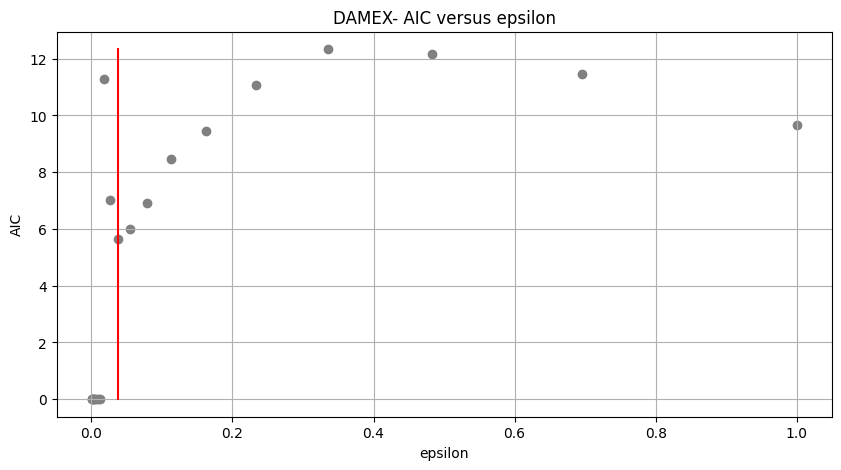

epsilon parameter selection (AIC):
0.038
DAMEX: selected epsilon with CV criterion 0.038


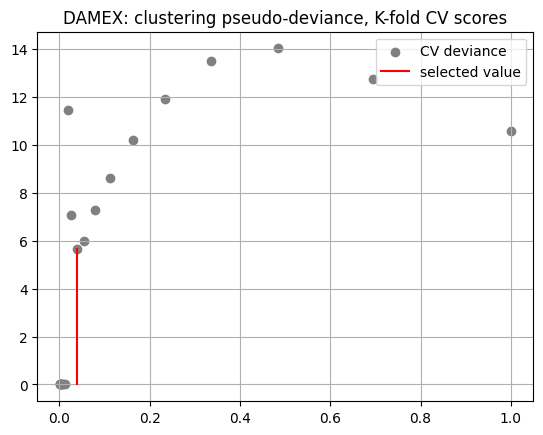

epsilon parameter selection (CV):
0.038


False

In [20]:
# select epsilon with AIC and update model:
neps = 20
eps_vect = np.geomspace(10**(-3), 1, num=neps)
eps_select_AIC, aic_opt, aic_values = clustering.select_epsilon_AIC(
    eps_vect, X, plot=True, update_epsilon=False)

print('epsilon parameter selection (AIC):')
print(mlx.round_signif(eps_select_AIC, 2))

# select epsilon with CV but don't update model:
eps_select_CV, _, _ = clustering.select_epsilon_CV(eps_vect, X, plot=True,
                                                   update_epsilon=False)

print('epsilon parameter selection (CV):')
print(mlx.round_signif(eps_select_CV, 2))

# Check that epsilon stored in object is still the default one
clustering.epsilon

## Wrapping up: Comparison of All Metrics:

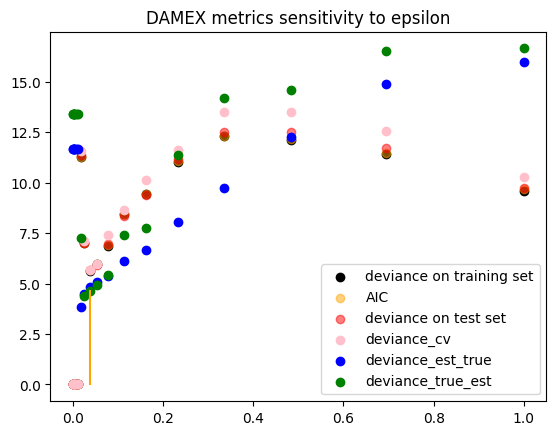

In [21]:
# # Agreement with other metrics: recommended choice of epsilon here: by CV
eps_select = eps_select_CV
i_select = np.where(eps_select == eps_vect)[0][0]
aic_vals = np.zeros(neps)
deviance = np.zeros(neps)
deviance_train = np.zeros(neps)
deviance_cv = np.zeros(neps)
deviance_est_true = np.zeros(neps)
deviance_true_est = np.zeros(neps)

for i in range(neps):
    clust = mlx.damex(epsilon=eps_vect[i], min_counts=min_counts,
                      thresh_train=threshold,
                      thresh_test=threshold,
                      include_singletons=include_singletons)
    faces, masses = clust.fit(Xt, standardize=False)
    aic_vals[i] = clust.get_AIC(Xt, standardize=False)
    deviance[i] = clust.deviance(std_Xtest, standardize=False)
    deviance_train[i] = clust.deviance(Xt, standardize=False)
    deviance_cv_scores = clust.deviance_CV(Xt, standardize=False,
                                           random_state=13+137*i, cv=5)
    deviance_cv[i] = np.mean(deviance_cv_scores)
    deviance_est_true[i], deviance_true_est[i] = clust.deviance_to_true(
        faces_true, wei_true)

if True:
    plt.scatter(eps_vect, deviance_train, c='black',
                label='deviance on training set')
    plt.scatter(eps_vect, aic_vals, c='orange', label='AIC', alpha=0.5)
    plt.scatter(eps_vect, deviance, c='red',
                label='deviance on test set', alpha=0.5)
    plt.scatter(eps_vect, deviance_cv, c='pink',
                label='deviance_cv')
    plt.scatter(eps_vect, deviance_est_true, c='blue',
                label='deviance_est_true')
    plt.scatter(eps_vect, deviance_true_est, c='green',
                label='deviance_true_est')
    plt.plot([eps_select, eps_select], [0, deviance_true_est[i_select]],
             c='orange')
    plt.legend()
    plt.title("DAMEX metrics sensitivity to epsilon")
    plt.show()

**Conclusion:** All goes as planned:

- Deviance on the testing set and AIC are very close or even
  indistinguishable as soon as epsilon is not too small, reflecting
  the fact that AIC is meant to estimate  the deviance on a test
  set.

- Deviance on the training set and AIC are close because the number of
  'parameters' of the model (i.e., number of faces) is small compared
  with the sample size (here, the number of extremes).

- Deviance on the training set is close to, but less than, the
  deviance on the test set, reflecting slight overfitting.

- Deviance on the test set is a reasonable approximation of the
  deviance of the estimated parameter from the true model (not the
  other way around).

- CV deviance is different from the test deviance but follows a
  similar pattern.

**Take-home message:** To choose epsilon, use `select_epsilon_AIC` and
  `select_epsilon_CV`. The results should be similar. If they are not,
  you may be in trouble because the (extreme) sample size may be too
  small.

In [22]:
# subfaces and masses
subfaces_select, masses_select = clustering.fit(Xt, eps_select, False)
weights_select = masses_select / np.sum(masses_select)

dict_faces_select, dict_weights_select = mlx.list_to_dict(subfaces_select,
                                                          weights_select)

print("Damex with selected epsilon: subfaces")
pp.pprint(dict_faces_select)
print("True subfaces")
pp.pprint(faces_dict_true)

print("final output: weights = normalized masses")
pp.pprint(dict_weights_select)
print("True weights")
pp.pprint(mass_dict_true)

Damex with selected epsilon: subfaces
{1: [],
 2: [[10, 13], [0, 5], [4, 8]],
 3: [[0, 3, 8]],
 4: [],
 5: [[7, 8, 13, 14, 17], [1, 3, 8, 14, 19]],
 6: [[2, 9, 11, 12, 16, 17], [0, 6, 7, 11, 16, 19]],
 7: [],
 8: [],
 9: [[1, 2, 4, 6, 9, 13, 15, 18, 19], [1, 2, 4, 6, 7, 9, 13, 15, 18]],
 10: [[0, 1, 2, 3, 4, 6, 7, 9, 12, 19], [1, 2, 4, 6, 7, 9, 13, 15, 18, 19]]}
True subfaces
{1: [],
 2: [[0, 5], [10, 13], [4, 8]],
 3: [[0, 3, 8]],
 4: [],
 5: [[7, 8, 13, 14, 17], [1, 3, 8, 14, 19]],
 6: [[0, 6, 7, 11, 16, 19], [2, 9, 11, 12, 16, 17]],
 7: [],
 8: [],
 9: [],
 10: [[0, 1, 2, 3, 4, 6, 7, 9, 12, 19], [1, 2, 4, 6, 7, 9, 13, 15, 18, 19]]}
final output: weights = normalized masses
{1: [],
 2: [0.11, 0.11, 0.065],
 3: [0.07],
 4: [],
 5: [0.12, 0.096],
 6: [0.14, 0.082],
 7: [],
 8: [],
 9: [0.023, 0.019],
 10: [0.088, 0.075]}
True weights
{1: [],
 2: [0.062, 0.067, 0.029],
 3: [0.042],
 4: [],
 5: [0.092, 0.083],
 6: [0.1, 0.13],
 7: [],
 8: [],
 9: [],
 10: [0.16, 0.22]}
